# Evaluating and Tuning a Binary Classification Model

## Goals

After this lesson, you should be able to:

- Build and explain confusion matrices from a model output
- Calculate various binary classification metrics
- Explain the AUC/ROC curve, why it matters, and how to use it
- Understand when and how to optimize a model for various metrics
- Optimize a classification model based on costs

### Category definitions - possible outcomes in binary classification
 
#### - TP = True Positive (class 1 correctly classified as class 1) - e.g. Patient with cancer tests positive for cancer
#### - TN = True Negative (class 0 correctly classified as class 0) - e.g. Patient without cancer tests negative for cancer
#### - FP = False Positive (class 0 incorrectly classified as class 1) - e.g. Patient without cancer tests positive for cancer
#### - FN = False Negative (class 1 incorrectly classified as class 0) - e.g. Patient with cancer tests negative for cancer

### $$ \text{Possible misclassifications} $$

![Type 1 vs. Type 2 Error](images/type-1-type-2.jpg)

## All the Binary Classification Metrics

![classification metrics](./images/conf_matrix_classification_metrics.png)

## Let's run a model and look at some metrics 

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

[Dataset info](https://archive.ics.uci.edu/ml/datasets/Heart+Disease)

In [2]:
df = pd.read_csv('./data/heart.csv')
df = pd.get_dummies(df, 
               columns = ['sex', 'cp', 'fbs', 'restecg', 'ca', 'slope', 'exang'], 
               drop_first= True) 
# drop first drops columns that would lead to milticollinearity

In [3]:
df.head()

,age,trestbps,chol,thalach,oldpeak,thal,target,sex_1,cp_1,cp_2,...,fbs_1,restecg_1,restecg_2,ca_1,ca_2,ca_3,ca_4,slope_1,slope_2,exang_1
0,63,145,233,150,2.3,1,1,1,0,0,...,1,0,0,0,0,0,0,0,0,0
1,37,130,250,187,3.5,2,1,1,0,1,...,0,1,0,0,0,0,0,0,0,0
2,41,130,204,172,1.4,2,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,56,120,236,178,0.8,2,1,1,1,0,...,0,1,0,0,0,0,0,0,1,0
4,57,120,354,163,0.6,2,1,0,0,0,...,0,1,0,0,0,0,0,0,1,1


In [4]:
df['target'].value_counts(normalize = True)
#differences are not severe

1    0.544554
0    0.455446
Name: target, dtype: float64

In [7]:
X = df.drop('target', axis = 1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 77, stratify = y, test_size = .2)
#train-test splitting
#stratify keeps ratios of y classes the same per each train-test group
#test_size at .2 when you have lots of data, increase with smaller dataset

**Data Leekage: when you incorporate test data when training your model with training data (DON'T TOUCH TEST DATA UNTIL END)**

In [9]:
# DATA LEEKAGE
from sklearn.preprocessing import StandardScaler

In [10]:
# DATA LEEKAGE
scaler = StandardScaler()

In [11]:
# DATA LEEKAGE
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [12]:
# DATA LEEKAGE
scaler.transform(X_test)

array([[ 1.34728449, -0.67541714, -0.37271932, ...,  1.06845352,
        -0.93593215,  1.42302495],
       [-0.18035937, -0.10530571, -0.9949091 , ..., -0.93593215,
        -0.93593215, -0.70272837],
       [-1.59888581,  1.14893944, -0.4893799 , ..., -0.93593215,
         1.06845352, -0.70272837],
       ...,
       [-0.07124195, -0.67541714,  0.19114017, ...,  1.06845352,
        -0.93593215, -0.70272837],
       [-2.14447291, -0.56139485, -1.09212625, ..., -0.93593215,
         1.06845352, -0.70272837],
       [ 0.14699289, -0.67541714, -1.07268282, ...,  1.06845352,
        -0.93593215, -0.70272837]])

In [14]:
## Let's check number of 1 and 0 in both datasets
y_train.mean(), y_test.mean()

(0.5454545454545454, 0.5409836065573771)

[Check sklearn for documentation of Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)


[For solvers](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)

In [17]:
## Let's go with the vanilla case - no regularization
lr = LogisticRegression(C = 1e9, solver = 'newton-cg', max_iter=10000)
lr.fit(X_train, y_train)

# C is the inverse of lambda, small c penalizes coefficients

LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='warn', n_jobs=None,
                   penalty='l2', random_state=None, solver='newton-cg',
                   tol=0.0001, verbose=0, warm_start=False)

In [18]:
lr.score(X_train, y_train)

0.8801652892561983

In [19]:
## What is this score?
print(lr.score(X_train, y_train), lr.score(X_test, y_test))

0.8801652892561983 0.8688524590163934


In [20]:
## Let's try one more time but this time with cross-validation

#split into 10 stratified
cv = StratifiedKFold(n_splits= 10, random_state=1019, shuffle=True)

#pick sections to compare
lr_vanilla = LogisticRegression(C = 1e9, 
                                solver = 'newton-cg',
                                max_iter=1000)

l2_reg = LogisticRegression(C = 1, 
                            solver = 'newton-cg',
                            max_iter=1000)

l1_reg = LogisticRegression(C = 1, 
                           solver= 'saga', 
                           penalty = 'l1',
                            max_iter=1000)

#cross validations (each has different methods)
cv_vanilla = cross_validate(estimator=lr_vanilla, 
                            X = X_train, y = y_train,
                            cv = cv, 
                            n_jobs=-1, 
                            return_estimator= True, 
                            return_train_score=True)

cv_l2 = cross_validate(estimator=l2_reg, 
                    X = X_train, y = y_train,
                    cv = cv, 
                    n_jobs=-1, 
                    return_estimator= True, 
                    return_train_score=True)

cv_l1 = cross_validate(estimator=l1_reg, 
                    X = X_train, y = y_train,
                    cv = cv, 
                    n_jobs=-1, 
                    return_estimator= True, 
                    return_train_score=True)

# want the test and training scores to be close
# don't want under or overfitted model

In [21]:
vanilla_result = np.concatenate((cv_vanilla['train_score'].reshape(-1,1), 
                cv_vanilla['test_score'].reshape(-1,1)), axis=1)

l2_result = np.concatenate((cv_l2['train_score'].reshape(-1,1), 
                cv_l2['test_score'].reshape(-1,1)), axis=1)

l1_result = np.concatenate((cv_l1['train_score'].reshape(-1,1), 
                cv_l1['test_score'].reshape(-1,1)), axis=1)

In [22]:
vanilla_result
# seeing train vs test scores
# this model is a little bit overfitted

array([[0.87096774, 0.88      ],
       [0.87557604, 0.92      ],
       [0.88073394, 0.83333333],
       [0.8853211 , 0.75      ],
       [0.88990826, 0.875     ],
       [0.89449541, 0.79166667],
       [0.89449541, 0.79166667],
       [0.90366972, 0.83333333],
       [0.8853211 , 0.79166667],
       [0.88073394, 0.79166667]])

In [23]:
l2_result

array([[0.88940092, 0.88      ],
       [0.86635945, 1.        ],
       [0.87614679, 0.875     ],
       [0.87614679, 0.875     ],
       [0.88073394, 0.875     ],
       [0.8853211 , 0.875     ],
       [0.90366972, 0.70833333],
       [0.90825688, 0.83333333],
       [0.88073394, 0.83333333],
       [0.8853211 , 0.83333333]])

In [33]:
l1_result

array([[0.7235023 , 0.64      ],
       [0.69124424, 0.84      ],
       [0.71100917, 0.70833333],
       [0.72477064, 0.625     ],
       [0.71100917, 0.75      ],
       [0.7293578 , 0.66666667],
       [0.71100917, 0.79166667],
       [0.72018349, 0.625     ],
       [0.71559633, 0.70833333],
       [0.71559633, 0.70833333]])

In [24]:
print(vanilla_result.mean(axis=0), l1_result.mean(axis=0), l2_result.mean(axis=0))

[0.88612227 0.82583333] [0.71532787 0.70633333] [0.88520906 0.85883333]


In [29]:
print(vanilla_result.std(axis=0), l1_result.mean(axis=0), l2_result.mean(axis=0))

[0.00928817 0.04975077] [0.71532787 0.70633333] [0.88520906 0.85883333]


In [ ]:
#now choose highest mean possible, and least standard deviation

In [31]:
lr = cv_l2['estimator'][0]
lr

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

### The Default Measure (in most prebuilt models) - Accuracy

$$ \frac{(TP + TN)}{(TP + FP + TN + FN)} $$

#### We got an accuracy score of .82, but what does that tell us? Just that 82% of the time we are correct, nothing about how we are correct or how we are wrong

In [26]:
predictions = lr.predict(X_test)
actual = y_test

In [27]:
confusion_matrix(actual, predictions)

array([[23,  5],
       [ 5, 28]])

#### My eyes!!!

In [28]:
pd.DataFrame(confusion_matrix(actual, predictions), 
             columns = ['predicted 0', 'predicted 1'], 
             index = ['actual 0', 'actual 1'])

,predicted 0,predicted 1
actual 0,23,5
actual 1,5,28


#### We got more false negatives than false positives. What would we likely prefer in the case of this dataset?

## Other metrics

### Misclassification Rate
#### $$ 1 - \text{accuracy} $$ 

### $$ {OR} $$

#### $$ \frac{FP + FN}{TP + FP + TN + FN} $$

### Sensitivity (AKA True Positive Rate, Recall, and Probability of Detection)

$$ \frac{TP}{TP + FN} $$

### Specificity (AKA True Negative Rate)

$$ \frac{TN}{TN + FP} $$

#### Which of these metrics would we want to optimize for in a heart disease detection algorithm?

False Positives and False Negatives each have some cost associated with them.

### Let's figure out how to optimize!

#### Remember that Logistic Regression gives probability predictions for each class, in addition to the final classification. By default, threshold for the prediction is set to 0.5, but we can adjust that threshold.

In [34]:
lr.predict(X_train) #by default threshold is 0.5

array([1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1])

In [35]:
lr.predict_proba(X_train) #poabability not sick vs probability sick

array([[0.17493232, 0.82506768],
       [0.27773932, 0.72226068],
       [0.1290169 , 0.8709831 ],
       [0.69685931, 0.30314069],
       [0.88243363, 0.11756637],
       [0.97778782, 0.02221218],
       [0.00359941, 0.99640059],
       [0.87952577, 0.12047423],
       [0.10409419, 0.89590581],
       [0.93669609, 0.06330391],
       [0.06855957, 0.93144043],
       [0.08878636, 0.91121364],
       [0.14062478, 0.85937522],
       [0.6518426 , 0.3481574 ],
       [0.86481498, 0.13518502],
       [0.09481083, 0.90518917],
       [0.69572788, 0.30427212],
       [0.26989101, 0.73010899],
       [0.09016365, 0.90983635],
       [0.97641471, 0.02358529],
       [0.75887801, 0.24112199],
       [0.03101708, 0.96898292],
       [0.76193852, 0.23806148],
       [0.96243299, 0.03756701],
       [0.22368022, 0.77631978],
       [0.8260458 , 0.1739542 ],
       [0.99084672, 0.00915328],
       [0.04541336, 0.95458664],
       [0.79714276, 0.20285724],
       [0.0097506 , 0.9902494 ],
       [0.

In [36]:
predicts = []
for item in lr.predict_proba(X_train):
    if item[0] <= .70: # you can play with this threshold
        predicts.append(1)
    else:
        predicts.append(0)

In [37]:
conf_matrix = pd.DataFrame(confusion_matrix(y_train, predicts),
                           index = ['actual 0', 'actual 1'], 
                           columns = ['predicted 0', 'predicted 1'])
conf_matrix

,predicted 0,predicted 1
actual 0,75,35
actual 1,5,127


In [20]:
## accuracy
(conf_matrix['predicted 0'][0] + conf_matrix['predicted 1'][1]) / len(predicts)

0.8157894736842105

### The AUC / ROC curve (Area Under Curve of the Receiver Operating Characteristic)

![a](images/pop-curve.png)

In [21]:
import matplotlib.pyplot as plt

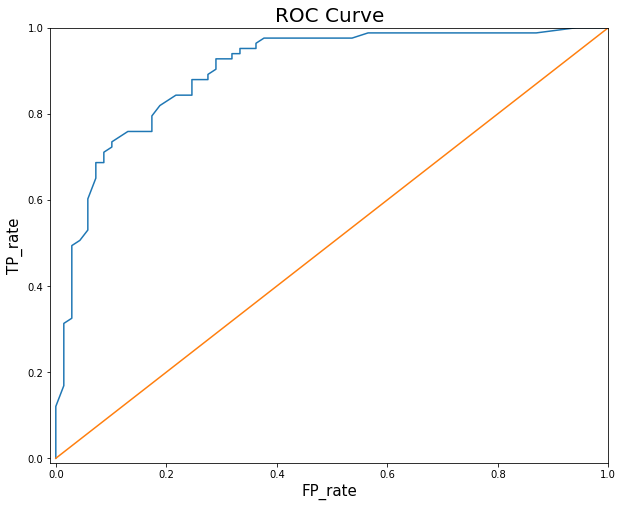

In [34]:
x_list = []
y_list = []

for x in np.linspace(0, 1, 100):
    
    # Same predictions based on predict_proba thresholds
    predicts = []
    
    for item in lr.predict_proba(X_test):
        if item[0] <= x:
            predicts.append(1)
        else:
            predicts.append(0)

    conf_matrix = pd.DataFrame(confusion_matrix(y_test, predicts), index = ['actual 0', 'actual 1'], 
                     columns = ['predicted 0', 'predicted 1'])
    
    
    # Assign TP, TN, FP, FN
    true_positives = conf_matrix['predicted 1'][1]
    true_negatives = conf_matrix['predicted 0'][0]
    false_positives = conf_matrix['predicted 1'][0]
    false_negatives = conf_matrix['predicted 0'][1]

    
    # Calculate Sensitivity and Specificity
    sensitivity = true_positives / (true_positives + false_negatives)

    specificity = true_negatives / (true_negatives + false_positives)
    
    
    # Append to lists to graph
    x_list.append(1 - specificity)

    y_list.append(sensitivity)

    
# Plot ROC curve

plt.figure(figsize = (10, 8))
plt.title('ROC Curve', fontsize = 20)
plt.xlabel('FP_rate', fontsize = 15)
plt.ylabel('TP_rate', fontsize = 15)
plt.xlim(-0.01, 1)
plt.ylim(-0.01, 1)
plt.plot(x_list, y_list);
plt.plot([0, 1], [0, 1]);

# x = 1 - specificity
# y = sensitivity

In [23]:
from sklearn.metrics import auc

In [24]:
auc(x_list, y_list)

0.9011698969792212

### Let's add associated costs to our False Negatives and False Positives to our loop and minimize the cost
This is the naive way to optimize, but works well - you could also create a closed form optimization function

In [25]:
def my_eyes_cost_much(num_thres = 100, p_fp = 3, p_tn = 0.5, p_tp = 1, p_fn = 2):

    _thres = []; tpr = [] ; fpr = [] ; cost = []

    prediction = lr.predict_proba(X_test)

    ## Different code for same objective to calculate metrics at thresholds
    
    for thres in np.linspace(0.01, 1, num_thres):
        
        _thres.append(thres)
        predicts = np.zeros((prediction.shape[0], 1)) 
        predicts[np.where(prediction[:, 1] >= thres)] = 1

        conf_matrix = confusion_matrix(y_test, predicts)

        tp = conf_matrix[1, 1]
        tn = conf_matrix[0, 0]
        fp = conf_matrix[0, 1]
        fn = conf_matrix[1, 0]

        sensitivity = tp / (tp + fn)
        tnr = specificity = tn / (tn + fp)
        fnr = 1 - sensitivity

        tpr.append(sensitivity)
    
        fpr.append(1 - specificity)
        
        # add a cost function (this involves domain knowledge)
        
        current_cost = (p_fp * fp) + (p_tn * tn) + (p_tp * tp) + (p_fn * fn)
            
        cost.append(current_cost)  

    return fpr, tpr, cost, _thres

In [26]:
fpr, tpr, cost, thres = my_eyes_cost_much(num_thres = 100, p_fp = 3, p_tn = 0.5, p_tp = 1, p_fn = 2)

In [41]:
cost_idx = np.argmin(cost)
min_cost_threshold = fpr[cost_idx], tpr[cost_idx], thres[cost_idx]

print(min_cost_threshold)

(0.07246376811594202, 0.6867469879518072, 0.73)


Text(0.13246376811594202, 0.6567469879518072, 'Threshold:0.73')

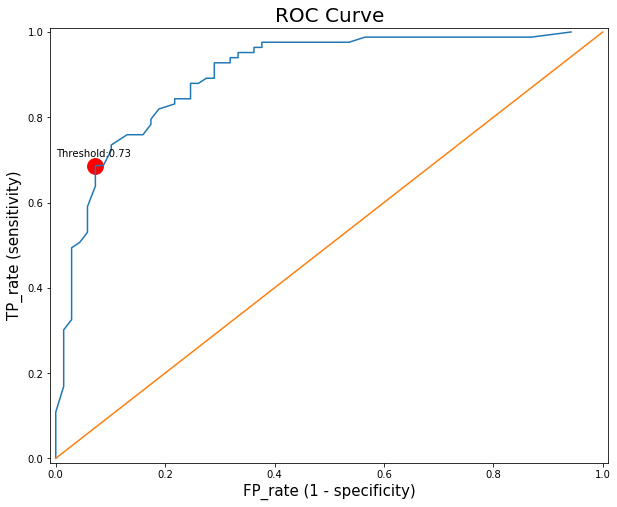

In [43]:
ax = plt.figure(figsize = (10, 8))
plt.title('ROC Curve', fontsize = 20)
plt.xlabel('FP_rate (1 - specificity)', fontsize = 15)
plt.ylabel('TP_rate (sensitivity)', fontsize = 15)
plt.xlim(-.01, 1.01)
plt.ylim(-.01, 1.01)
plt.plot(fpr, tpr);
plt.plot([0, 1], [0, 1]);
plt.scatter(min_cost_threshold[0], min_cost_threshold[1], marker ='o', color = 'red', s=250)
ax.text(min_cost_threshold[0] + 0.06, min_cost_threshold[1] - 0.03, 'Threshold:'+ str(round(min_cost_threshold[2], 2)))


### Visualizing Threshold vs. Population Distribution

In [29]:
import seaborn as sns

In [30]:
lr.predict_proba(X_test)[:5]

array([[0.01329378, 0.98670622],
       [0.29154919, 0.70845081],
       [0.34072097, 0.65927903],
       [0.08327691, 0.91672309],
       [0.82535108, 0.17464892]])

In [31]:
lr.predict(X_test)[:5]

array([1, 1, 1, 1, 0])

In [40]:
# no_cancer_dist = []
# cancer_dist = []

# for item in lr.predict_proba(X_test):
#     if item[0] <= .49:
#         cancer_dist.append(item[0])
#     else:
#         no_cancer_dist.append(item[0])
        
# plt.figure(figsize = (10, 6))
# plt.title('Distributions of Patients with and without Cancer')
# plt.xlabel('Threshold', fontsize = 14)

# sns.distplot(no_cancer_dist, bins = 15, color = 'red')
# sns.distplot(cancer_dist, bins = 15, color = 'blue')
# plt.legend(['no cancer dist', 'cancer dist']);

### ROC curve vs Population Separation
![a](images/pop-curve.png)

![d](images/varying_dist_roc.png)

### Precision (Positive Predictive Value)

### $$ \frac{TP}{TP + FP}  $$

### F1 Score

### $$ 2 * \frac{\text{Precision * Recall}}{\text{Precision + Recall}} $$